# Notebook exploring effects of CO<sub>2</sub> emmissions on the global climate

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as pt

In [3]:
class Power(pt.nn.Module):
    def __init__(self, p):
        super(Power, self).__init__()
        self.p = p
        self.weight = pt.nn.Parameter(pt.Tensor([[1.0]]))
        self.bias = pt.nn.Parameter(pt.Tensor([[0.0]]))
    
    def forward(self, tensor):
        return (tensor + self.bias) ** self.p
    
    
class Exp(pt.nn.Module):
    def __init__(self):
        super(Exp, self).__init__()
        self.weight = pt.nn.Parameter(pt.Tensor([[1.0]]))
        self.bias = pt.nn.Parameter(pt.Tensor([[0.0]]))
    
    def forward(self, tensor):
        return pt.exp(self.weight * tensor + self.bias)

In [4]:
N_EPOCHS = 10000
LR0 = 1e-3
LR1 = 1e-7
FUNCTIONS = [
    Power(1),
    Power(2),
    Power(3),
    Power(4),
    Power(5),
    Exp()
]
FUNCTION_NAMES = [
    'x^1',
    'x^2',
    'x^3',
    'x^4',
    'x^5',
    'e^(x)'
]
FUNCTION_NAMES_TO_FORMAT = {
    'x^1': 'x^{1}', 
    'x^2': 'x^{2}', 
    'x^3': 'x^{3}', 
    'x^4': 'x^{4}', 
    'x^5': 'x^{5}', 
    'e^(x)': 'e^{x}'
}
criterion = pt.nn.MSELoss()

In [5]:
class TestModel(pt.nn.Module):
    def __init__(self, f):
        super(TestModel, self).__init__()
        self.layer0 = f
        self.layer1 = pt.nn.Linear(1, 1)
        pt.nn.init.constant_(self.layer0.weight, 1.0)
        pt.nn.init.constant_(self.layer0.bias, 0.0)
        pt.nn.init.constant_(self.layer1.weight, 0.0)
        pt.nn.init.constant_(self.layer1.bias, 0.0)
    
    def forward(self, x):
        a0 = self.layer0(x)
        a1 = self.layer1(a0)
        return a1

In [6]:
def train_test_split(x=None, y=None, train_size=None):
    if train_size is None:
        raise ValueError
    if x is None and y is None:
        raise ValueError
    elif x is None:
        return y[:train_size], y[train_size:]
    elif y is None:
        return x[:train_size], x[train_size:]
    return (x[:train_size], x[train_size:]), (y[:train_size], y[train_size:])

In [7]:
N_YEARS = 2011 - 1879
YEARS = np.arange(N_YEARS) + 1880

## Analysis of global temperature

In [8]:
TEMPERATURE_URL = 'https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt'
resp = requests.get(TEMPERATURE_URL)
temperature_data = np.array([row.split() for row in resp.text.split('\n')[5:-9]])[:, :2]

In [9]:
temperature_deviation = pd.DataFrame(temperature_data, columns=['year', 'deviation'])
temperature_deviation['year'] = YEARS
temperature_deviation['deviation'] = temperature_deviation['deviation'].astype(np.float32)
temperature_deviation.to_csv('data/temperature_deviation.csv', index=False)

In [10]:
absolute_temperature = pd.DataFrame(temperature_data, columns=['year', 'temperature'])
absolute_temperature['year'] = YEARS
absolute_temperature['temperature'] = absolute_temperature['temperature'].astype(np.float32) + 14.0 + 273.15
absolute_temperature.to_csv('data/absolute_temperature.csv', index=False)

In [11]:
temperature_x = pt.Tensor(YEARS.reshape(-1, 1))
TEMPERATURE_X_MEAN = temperature_x.mean()
TEMPERATURE_X_STD = temperature_x.std()
temperature_x -= TEMPERATURE_X_MEAN
temperature_x /= TEMPERATURE_X_STD
temperature_y = pt.Tensor(absolute_temperature['temperature'].to_numpy().reshape(-1, 1)).detach() + 0.0
TEMPERATURE_Y_MEAN = temperature_y.mean()
TEMPERATURE_Y_STD = temperature_y.std()
temperature_y -= TEMPERATURE_Y_MEAN
temperature_y /= TEMPERATURE_Y_STD

In [12]:
temperature_linear_model = pt.nn.Sequential(
    pt.nn.Linear(1, 1)
)
linear_layer = list(temperature_linear_model.modules())[1]
weight = pt.nn.init.constant_(linear_layer.weight, 0.0)
bias = pt.nn.init.constant_(linear_layer.bias, 0.0)

In [13]:
temperature_linear_optim = pt.optim.SGD(temperature_linear_model.parameters(), lr=LR0)
for i in range(N_EPOCHS):
    if i == N_EPOCHS // 2:
        temperature_linear_optim = pt.optim.SGD(temperature_linear_model.parameters(), lr=LR1)
    y_hat = temperature_linear_model(temperature_x)
    loss = criterion(temperature_y, y_hat)
    loss.backward()
    temperature_linear_optim.step()
    temperature_linear_optim.zero_grad()
pt.save(temperature_linear_model.state_dict(), 'models/temperature_linear_model.pth')

In [14]:
linear_temperature_approximation = pd.DataFrame(np.concatenate([temperature_x.detach(), temperature_linear_model(temperature_x).detach() * TEMPERATURE_Y_STD + TEMPERATURE_Y_MEAN], axis=1), columns=['year', 'temperature'])
linear_temperature_approximation['year'] = YEARS
linear_temperature_approximation.to_csv('data/linear_temperature_approximation.csv', index=False)

In [14]:
temperature_models = []
temperature_performances = []
for i, f in enumerate(FUNCTIONS):
    test_model = TestModel(f)
    test_optim = pt.optim.SGD(test_model.parameters(), lr=LR0)
    for j in range(N_EPOCHS):
        if j == N_EPOCHS // 2:
            test_optim = pt.optim.SGD(test_model.parameters(), lr=LR1)
        y_hat = test_model(temperature_x)
        loss = criterion(temperature_y, y_hat)
        loss.backward()
        test_optim.step()
        test_optim.zero_grad()
    temperature_models.append(test_model)
    temperature_performances.append(loss.item())

In [15]:
best_temperature_model_i = np.argmin(temperature_performances)
for i, function in enumerate(FUNCTION_NAMES):
    print(f'{function}: {" " * (12 - len(function))}{round(temperature_performances[i], 3)}')
best_temperature_model = temperature_models[best_temperature_model_i]
pt.save(best_temperature_model.state_dict(), 'models/best_temperature_model.pth')
best_temperature_function = FUNCTION_NAMES[best_temperature_model_i]
best_temperature_formated_function = FUNCTION_NAMES_TO_FORMAT[best_temperature_function] if best_temperature_model_i != 5 else 'e^{' + str(round(list(best_temperature_model.parameters())[0].item(), 2)) + '}'
print()
print(f'Best function for approximation of temperatures is {best_temperature_function} with a loss of {round(np.min(temperature_performances), 3)}')

x^1:          0.28
x^2:          0.157
x^3:          0.202
x^4:          0.212
x^5:          0.292
e^(x):        0.161

Best function for approximation of temperatures is x^2 with a loss of 0.157


In [16]:
best_temperature_approximation = pd.DataFrame(np.concatenate([temperature_x.detach(), best_temperature_model(temperature_x).detach() * TEMPERATURE_Y_STD + TEMPERATURE_Y_MEAN], axis=1), columns=['year', 'temperature'])
best_temperature_approximation['year'] = YEARS
best_temperature_approximation.to_csv('data/best_temperature_approximation.csv', index=False)

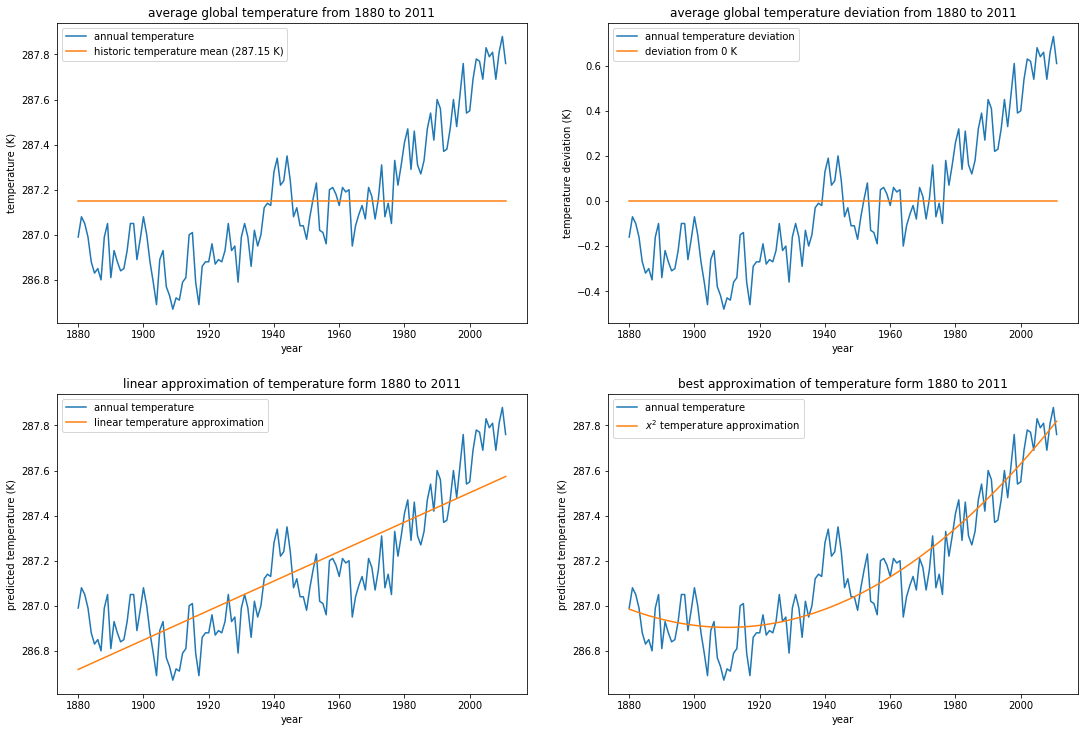

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(16, 11))
fig.tight_layout(pad=5.0)
ax[0, 0].plot(YEARS, absolute_temperature['temperature'], label='annual temperature')
ax[0, 0].plot(YEARS, [287.15] * N_YEARS, label='historic temperature mean (287.15 K)')
ax[0, 0].set_title('average global temperature from 1880 to 2011')
ax[0, 0].set_xlabel('year')
ax[0, 0].set_ylabel('temperature (K)')
ax[0, 0].legend()
ax[0, 1].plot(YEARS, temperature_deviation['deviation'], label='annual temperature deviation')
ax[0, 1].plot(YEARS, [0.0] * N_YEARS, label='deviation from 0 K')
ax[0, 1].set_title('average global temperature deviation from 1880 to 2011')
ax[0, 1].set_xlabel('year')
ax[0, 1].set_ylabel('temperature deviation (K)')
ax[0, 1].legend()
ax[1, 0].plot(YEARS, absolute_temperature['temperature'], label='annual temperature')
ax[1, 0].plot(YEARS, linear_temperature_approximation['temperature'], label='linear temperature approximation')
ax[1, 0].set_title('linear approximation of temperature form 1880 to 2011')
ax[1, 0].set_xlabel('year')
ax[1, 0].set_ylabel('predicted temperature (K)')
ax[1, 0].legend()
ax[1, 1].plot(YEARS, absolute_temperature['temperature'], label='annual temperature')
ax[1, 1].plot(YEARS, best_temperature_approximation['temperature'], label=f'${best_temperature_formated_function}$ temperature approximation')
ax[1, 1].set_title('best approximation of temperature form 1880 to 2011')
ax[1, 1].set_xlabel('year')
ax[1, 1].set_ylabel('predicted temperature (K)')
ax[1, 1].legend()
plt.savefig('results/temperature_analysis.pdf')
plt.show()

## Analysis of CO<sub>2</sub> emmissions

In [20]:
EMMISSION_DATA_LOCATION = 'data/annual_co2_emmissions_by_region.csv'
co2_data = pd.read_csv(EMMISSION_DATA_LOCATION)
co2_data = co2_data.groupby('Year').sum()
co2_data.columns = ['emmissions']

In [21]:
co2_emmissions = pd.DataFrame(columns=['year', 'emmissions'])
co2_emmissions['year'] = YEARS
co2_emmissions['emmissions'] = co2_data['emmissions'][129:-6].values / 1e6
co2_emmissions.to_csv('data/co2_emmissions.csv', index=False)

In [22]:
emmission_change = pd.DataFrame(columns=['year', 'change'])
emmission_change['year'] = YEARS
emmission_change['change'] = (co2_data['emmissions'][129:-6].values - co2_data['emmissions'][128:-7].values) / 1e6
emmission_change.to_csv('data/co2_emmission_change.csv', index=False)

In [23]:
CO2_LEVEL_URL = 'https://data.giss.nasa.gov/modelforce/ghgases/Fig1A.ext.txt'
resp = requests.get(CO2_LEVEL_URL)
co2_level_data = resp.text.split('\n')[5:-75]
co2_level = pd.DataFrame(columns=['year', 'level'])
for row in co2_level_data[30:]:
    data = float(row[14:19])
    co2_level = co2_level.append(pd.DataFrame([[None, data]], columns=['year', 'level']))
for row in co2_level_data:
    data = float(row[34:39])
    co2_level = co2_level.append(pd.DataFrame([[None, data]], columns=['year', 'level']))
for row in co2_level_data:
    data = float(row[54:59])
    co2_level = co2_level.append(pd.DataFrame([[None, data]], columns=['year', 'level']))
for row in co2_level_data[:12]:
    data = float(row[74:79])
    co2_level = co2_level.append(pd.DataFrame([[None, data]], columns=['year', 'level']))
co2_level['year'] = YEARS.reshape(-1, 1)
co2_level = co2_level.reset_index()
co2_level = co2_level.drop('index', axis=1)
co2_level.to_csv('data/co2_level.csv', index=False)

In [24]:
co2_level_before = pd.DataFrame([[1879, float(co2_level_data[29][14:19])]], columns=['year', 'level']).append(co2_level[:-1])
co2_level_before = co2_level_before.reset_index()
co2_level_before = co2_level_before.drop('index', axis=1)
co2_level_change = pd.DataFrame(columns=['year', 'change'])
co2_level_change['year'] = YEARS
co2_level_change['change'] = co2_level['level'] - co2_level_before['level']
co2_level_change.to_csv('data/co2_level_change.csv', index=False)

In [25]:
emmission_x = pt.Tensor(YEARS.reshape(-1, 1))
EMMISSION_X_MEAN = emmission_x.mean()
EMMISSION_X_STD = emmission_x.std()
emmission_x -= EMMISSION_X_MEAN
emmission_x /= EMMISSION_X_STD
emmission_y = pt.Tensor(co2_emmissions['emmissions'].to_numpy().reshape(-1, 1)).detach() + 0.0
EMMISSION_Y_MEAN = emmission_y.mean()
EMMISSION_Y_STD = emmission_y.std()
emmission_y -= EMMISSION_Y_MEAN
emmission_y /= EMMISSION_Y_STD

In [26]:
emmission_change_x = pt.Tensor(YEARS.reshape(-1, 1))
EMMISSION_CHANGE_X_MEAN = emmission_change_x.mean()
EMMISSION_CHANGE_X_STD = emmission_change_x.std()
emmission_change_x -= EMMISSION_CHANGE_X_MEAN
emmission_change_x /= EMMISSION_CHANGE_X_STD
emmission_change_y = pt.Tensor(emmission_change['change'].to_numpy().reshape(-1, 1)).detach() + 0.0
EMMISSION_CHANGE_Y_MEAN = emmission_change_y.mean()
EMMISSION_CHANGE_Y_STD = emmission_change_y.std()
emmission_change_y -= EMMISSION_CHANGE_Y_MEAN
emmission_change_y /= EMMISSION_CHANGE_Y_STD

In [27]:
co2_level_x = pt.Tensor(YEARS.reshape(-1, 1))
CO2_LEVEL_X_MEAN = co2_level_x.mean()
CO2_LEVEL_X_STD = co2_level_x.std()
co2_level_x -= CO2_LEVEL_X_MEAN
co2_level_x /= CO2_LEVEL_X_STD
co2_level_y = pt.Tensor(co2_level['level'].to_numpy().reshape(-1, 1)).detach() + 0.0
CO2_LEVEL_Y_MEAN = co2_level_y.mean()
CO2_LEVEL_Y_STD = co2_level_y.std()
co2_level_y -= CO2_LEVEL_Y_MEAN
co2_level_y /= CO2_LEVEL_Y_STD

In [28]:
co2_level_change_x = pt.Tensor(YEARS.reshape(-1, 1))
CO2_LEVEL_CHANGE_X_MEAN = co2_level_change_x.mean()
CO2_LEVEL_CHANGE_X_STD = co2_level_change_x.std()
co2_level_change_x -= CO2_LEVEL_CHANGE_X_MEAN
co2_level_change_x /= CO2_LEVEL_CHANGE_X_STD
co2_level_change_y = pt.Tensor(co2_level_change['change'].to_numpy().reshape(-1, 1)).detach() + 0.0
CO2_LEVEL_CHANGE_Y_MEAN = co2_level_change_y.mean()
CO2_LEVEL_CHANGE_Y_STD = co2_level_change_y.std()
co2_level_change_y -= CO2_LEVEL_CHANGE_Y_MEAN
co2_level_change_y /= CO2_LEVEL_CHANGE_Y_STD

In [29]:
emmission_linear_model = pt.nn.Sequential(
    pt.nn.Linear(1, 1)
)
linear_layer = list(emmission_linear_model.modules())[1]
weight = pt.nn.init.constant_(linear_layer.weight, 0.0)
bias = pt.nn.init.constant_(linear_layer.bias, 0.0)

In [29]:
emmission_linear_optim = pt.optim.SGD(emmission_linear_model.parameters(), lr=LR0)
for i in range(N_EPOCHS):
    if i == N_EPOCHS // 2:
        emmission_linear_optim = pt.optim.SGD(emmission_linear_model.parameters(), lr=LR1)
    y_hat = emmission_linear_model(emmission_x)
    loss = criterion(emmission_y, y_hat)
    loss.backward()
    emmission_linear_optim.step()
    emmission_linear_optim.zero_grad()
pt.save(emmission_linear_model.state_dict(), 'models/emmission_linear_model.pth')

In [30]:
linear_emmissions_approximation = pd.DataFrame(np.concatenate([emmission_x.detach(), emmission_linear_model(emmission_x).detach() * EMMISSION_Y_STD + EMMISSION_Y_MEAN], axis=1), columns=['year', 'emmission'])
linear_emmissions_approximation['year'] = YEARS
linear_emmissions_approximation.to_csv('data/linear_co2_emmission_approximation.csv', index=False)

In [31]:
emmission_change_linear_model = pt.nn.Sequential(
    pt.nn.Linear(1, 1)
)
linear_layer = list(emmission_change_linear_model.modules())[1]
weight = pt.nn.init.constant_(linear_layer.weight, 0.0)
bias = pt.nn.init.constant_(linear_layer.bias, 0.0)

In [32]:
emmission_change_linear_optim = pt.optim.SGD(emmission_change_linear_model.parameters(), lr=LR0)
for i in range(N_EPOCHS):
    if i == N_EPOCHS // 2:
        emmission_change_linear_optim = pt.optim.SGD(emmission_change_linear_model.parameters(), lr=LR1)
    y_hat = emmission_change_linear_model(emmission_x)
    loss = criterion(emmission_change_y, y_hat)
    loss.backward()
    emmission_change_linear_optim.step()
    emmission_change_linear_optim.zero_grad()
pt.save(emmission_change_linear_model.state_dict(), 'models/emmission_change_linear_model.pth')

In [33]:
linear_emmissions_change_approximation = pd.DataFrame(np.concatenate([emmission_change_x.detach(), emmission_change_linear_model(emmission_change_x).detach() * EMMISSION_CHANGE_Y_STD + EMMISSION_CHANGE_Y_MEAN], axis=1), columns=['year', 'change'])
linear_emmissions_change_approximation['year'] = YEARS
linear_emmissions_change_approximation.to_csv('data/linear_co2_emmission_change_approximation.csv', index=False)

In [34]:
co2_level_linear_model = pt.nn.Sequential(
    pt.nn.Linear(1, 1)
)
linear_layer = list(co2_level_linear_model.modules())[1]
weight = pt.nn.init.constant_(linear_layer.weight, 0.0)
bias = pt.nn.init.constant_(linear_layer.bias, 0.0)

In [35]:
co2_level_linear_optim = pt.optim.SGD(co2_level_linear_model.parameters(), lr=LR0)
for i in range(N_EPOCHS):
    if i == N_EPOCHS // 2:
        co2_level_linear_optim = pt.optim.SGD(co2_level_linear_model.parameters(), lr=LR1)
    y_hat = co2_level_linear_model(co2_level_x)
    loss = criterion(co2_level_y, y_hat)
    loss.backward()
    co2_level_linear_optim.step()
    co2_level_linear_optim.zero_grad()
pt.save(co2_level_linear_model.state_dict(), 'models/co2_level_linear_model.pth')

In [36]:
linear_co2_level_approximation = pd.DataFrame(np.concatenate([co2_level_x.detach(), co2_level_linear_model(co2_level_x).detach() * CO2_LEVEL_Y_STD + CO2_LEVEL_Y_MEAN], axis=1), columns=['year', 'level'])
linear_co2_level_approximation['year'] = YEARS
linear_co2_level_approximation.to_csv('data/linear_co2_level_approximation.csv', index=False)

In [37]:
co2_level_change_linear_model = pt.nn.Sequential(
    pt.nn.Linear(1, 1)
)
linear_layer = list(co2_level_change_linear_model.modules())[1]
weight = pt.nn.init.constant_(linear_layer.weight, 0.0)
bias = pt.nn.init.constant_(linear_layer.bias, 0.0)

In [39]:
co2_level_change_linear_optim = pt.optim.SGD(co2_level_change_linear_model.parameters(), lr=LR0)
for i in range(N_EPOCHS):
    if i == N_EPOCHS // 2:
        co2_level_change_linear_optim = pt.optim.SGD(co2_level_change_linear_model.parameters(), lr=LR1)
    y_hat = co2_level_change_linear_model(co2_level_change_x)
    loss = criterion(co2_level_change_y, y_hat)
    loss.backward()
    co2_level_change_linear_optim.step()
    co2_level_change_linear_optim.zero_grad()
pt.save(co2_level_change_linear_model.state_dict(), 'models/c02_level_change_linear_model.pth')

In [40]:
linear_co2_level_change_approximation = pd.DataFrame(np.concatenate([co2_level_change_x.detach(), co2_level_change_linear_model(co2_level_change_x).detach() * CO2_LEVEL_CHANGE_Y_STD + CO2_LEVEL_CHANGE_Y_MEAN], axis=1), columns=['year', 'change'])
linear_co2_level_change_approximation['year'] = YEARS
linear_co2_level_change_approximation.to_csv('data/linear_co2_level_change_approximation.csv', index=False)

In [41]:
emmission_models = []
emmission_performances = []
for i, f in enumerate(FUNCTIONS):
    test_model = TestModel(f)
    test_optim = pt.optim.SGD(test_model.parameters(), lr=LR0)
    for j in range(N_EPOCHS):
        if j == N_EPOCHS // 2:
            test_optim = pt.optim.SGD(test_model.parameters(), lr=LR1)
        y_hat = test_model(emmission_x)
        loss = criterion(emmission_y, y_hat)
        loss.backward()
        test_optim.step()
        test_optim.zero_grad()
    emmission_models.append(test_model)
    emmission_performances.append(loss.item())

In [42]:
best_emmission_model_i = np.argmin(emmission_performances)
for i, function in enumerate(FUNCTION_NAMES):
    print(f'{function}: {" " * (12 - len(function))}{round(emmission_performances[i], 3)}')
best_emmission_model = emmission_models[best_emmission_model_i]
pt.save(best_emmission_model.state_dict(), 'models/best_emmission_model.pth')
best_emmission_function = FUNCTION_NAMES[best_emmission_model_i]
best_emmission_formated_function = FUNCTION_NAMES_TO_FORMAT[best_emmission_function] if best_emmission_model_i != 5 else 'e^{' + str(round(list(best_emmission_model.parameters())[0].item(), 2)) + '}'
print()
print(f'Best function for approximation of CO₂ emmissions is {best_emmission_function} with a loss of {round(np.min(emmission_performances), 3)}')

x^1:          0.142
x^2:          0.024
x^3:          0.094
x^4:          0.105
x^5:          0.281
e^(x):        0.044

Best function for approximation of CO₂ emmissions is x^2 with a loss of 0.024


In [43]:
best_emmission_approximation = pd.DataFrame(np.concatenate([emmission_x.detach(), best_emmission_model(emmission_x).detach() * EMMISSION_Y_STD + EMMISSION_Y_MEAN], axis=1), columns=['year', 'emmission'])
best_emmission_approximation['year'] = YEARS
best_emmission_approximation.to_csv('data/best_co2_emmission_approximation.csv', index=False)

In [44]:
emmission_change_models = []
emmission_change_performances = []
for i, f in enumerate(FUNCTIONS):
    test_model = TestModel(f)
    test_optim = pt.optim.SGD(test_model.parameters(), lr=LR0)
    for j in range(N_EPOCHS):
        if j == N_EPOCHS // 2:
            test_optim = pt.optim.SGD(test_model.parameters(), lr=LR1)
        y_hat = test_model(emmission_change_x)
        loss = criterion(emmission_change_y, y_hat)
        loss.backward()
        test_optim.step()
        test_optim.zero_grad()
    emmission_change_models.append(test_model)
    emmission_change_performances.append(loss.item())

In [45]:
best_emmission_change_model_i = np.argmin(emmission_change_performances)
for i, function in enumerate(FUNCTION_NAMES):
    print(f'{function}: {" " * (12 - len(function))}{round(emmission_change_performances[i], 3)}')
best_emmission_change_model = emmission_change_models[best_emmission_change_model_i]
pt.save(best_emmission_change_model.state_dict(), 'models/best_emmission_change_model.pth')
best_emmission_change_function = FUNCTION_NAMES[best_emmission_change_model_i]
best_emmission_change_formated_function = FUNCTION_NAMES_TO_FORMAT[best_emmission_change_function] if best_emmission_change_model_i != 5 else 'e^{' + str(round(list(best_emmission_change_model.parameters())[0].item(), 2)) + '}'
print()
print(f'Best function for approximation of CO₂ emmission change is {best_emmission_change_function} with a loss of {round(np.min(emmission_change_performances), 3)}')

x^1:          0.781
x^2:          0.788
x^3:          0.809
x^4:          0.823
x^5:          0.819
e^(x):        0.778

Best function for approximation of CO₂ emmission change is e^(x) with a loss of 0.778


In [46]:
best_emmission_change_approximation = pd.DataFrame(np.concatenate([emmission_change_x.detach(), best_emmission_change_model(emmission_change_x).detach() * EMMISSION_CHANGE_Y_STD + EMMISSION_CHANGE_Y_MEAN], axis=1), columns=['year', 'change'])
best_emmission_change_approximation['year'] = YEARS
best_emmission_change_approximation.to_csv('data/best_co2_emmission_change_approximation.csv', index=False)

In [47]:
co2_level_models = []
co2_level_performances = []
for i, f in enumerate(FUNCTIONS):
    test_model = TestModel(f)
    test_optim = pt.optim.SGD(test_model.parameters(), lr=LR0)
    for j in range(N_EPOCHS):
        if j == N_EPOCHS // 2:
            test_optim = pt.optim.SGD(test_model.parameters(), lr=LR1)
        y_hat = test_model(co2_level_x)
        loss = criterion(co2_level_y, y_hat)
        loss.backward()
        test_optim.step()
        test_optim.zero_grad()
    co2_level_models.append(test_model)
    co2_level_performances.append(loss.item())

In [48]:
best_co2_level_model_i = np.argmin(co2_level_performances)
for i, function in enumerate(FUNCTION_NAMES):
    print(f'{function}: {" " * (12 - len(function))}{round(co2_level_performances[i], 3)}')
best_co2_level_model = co2_level_models[best_co2_level_model_i]
pt.save(best_co2_level_model.state_dict(), 'models/best_co2_level_model.pth')
best_co2_level_function = FUNCTION_NAMES[best_co2_level_model_i]
best_co2_level_formated_function = FUNCTION_NAMES_TO_FORMAT[best_co2_level_function] if best_co2_level_model_i != 5 else 'e^{' + str(round(list(best_co2_level_model.parameters())[0].item(), 2)) + '}'
print()
print(f'Best function for approximation of CO₂ level is {best_co2_level_function} with a loss of {round(np.min(co2_level_performances), 3)}')

x^1:          0.14
x^2:          0.025
x^3:          0.037
x^4:          0.063
x^5:          0.177
e^(x):        0.015

Best function for approximation of CO₂ level is e^(x) with a loss of 0.015


In [49]:
best_co2_level_approximation = pd.DataFrame(np.concatenate([co2_level_x.detach(), best_co2_level_model(co2_level_x).detach() * CO2_LEVEL_Y_STD + CO2_LEVEL_Y_MEAN], axis=1), columns=['year', 'level'])
best_co2_level_approximation['year'] = YEARS
best_co2_level_approximation.to_csv('data/best_co2_level_approximation.csv', index=False)

In [50]:
co2_level_change_models = []
co2_level_change_performances = []
for i, f in enumerate(FUNCTIONS):
    test_model = TestModel(f)
    test_optim = pt.optim.SGD(test_model.parameters(), lr=LR0)
    for j in range(N_EPOCHS):
        if j == N_EPOCHS // 2:
            test_optim = pt.optim.SGD(test_model.parameters(), lr=LR1)
        y_hat = test_model(co2_level_change_x)
        loss = criterion(co2_level_change_y, y_hat)
        loss.backward()
        test_optim.step()
        test_optim.zero_grad()
    co2_level_change_models.append(test_model)
    co2_level_change_performances.append(loss.item())

In [51]:
best_co2_level_change_model_i = np.argmin(co2_level_change_performances)
for i, function in enumerate(FUNCTION_NAMES):
    print(f'{function}: {" " * (12 - len(function))}{round(co2_level_change_performances[i], 3)}')
best_co2_level_change_model = co2_level_models[best_co2_level_change_model_i]
pt.save(best_co2_level_change_model.state_dict(), 'models/best_co2_level_change_model.pth')
best_co2_level_change_function = FUNCTION_NAMES[best_co2_level_change_model_i]
best_co2_level_change_formated_function = FUNCTION_NAMES_TO_FORMAT[best_co2_level_change_function] if best_co2_level_change_model_i != 5 else 'e^{' + str(round(list(best_co2_level_change_model.parameters())[0].item(), 2)) + '}'
print()
print(f'Best function for approximation of CO₂ level change is {best_co2_level_change_function} with a loss of {round(np.min(co2_level_change_performances), 3)}')

x^1:          0.4
x^2:          0.246
x^3:          0.293
x^4:          0.319
x^5:          0.408
e^(x):        0.278

Best function for approximation of CO₂ level change is x^2 with a loss of 0.246


In [52]:
best_co2_level_change_approximation = pd.DataFrame(np.concatenate([co2_level_change_x.detach(), best_co2_level_change_model(co2_level_change_x).detach() * CO2_LEVEL_CHANGE_Y_STD + CO2_LEVEL_CHANGE_Y_MEAN], axis=1), columns=['year', 'change'])
best_co2_level_change_approximation['year'] = YEARS
best_co2_level_change_approximation.to_csv('data/best_co2_level_change_approximation.csv', index=False)

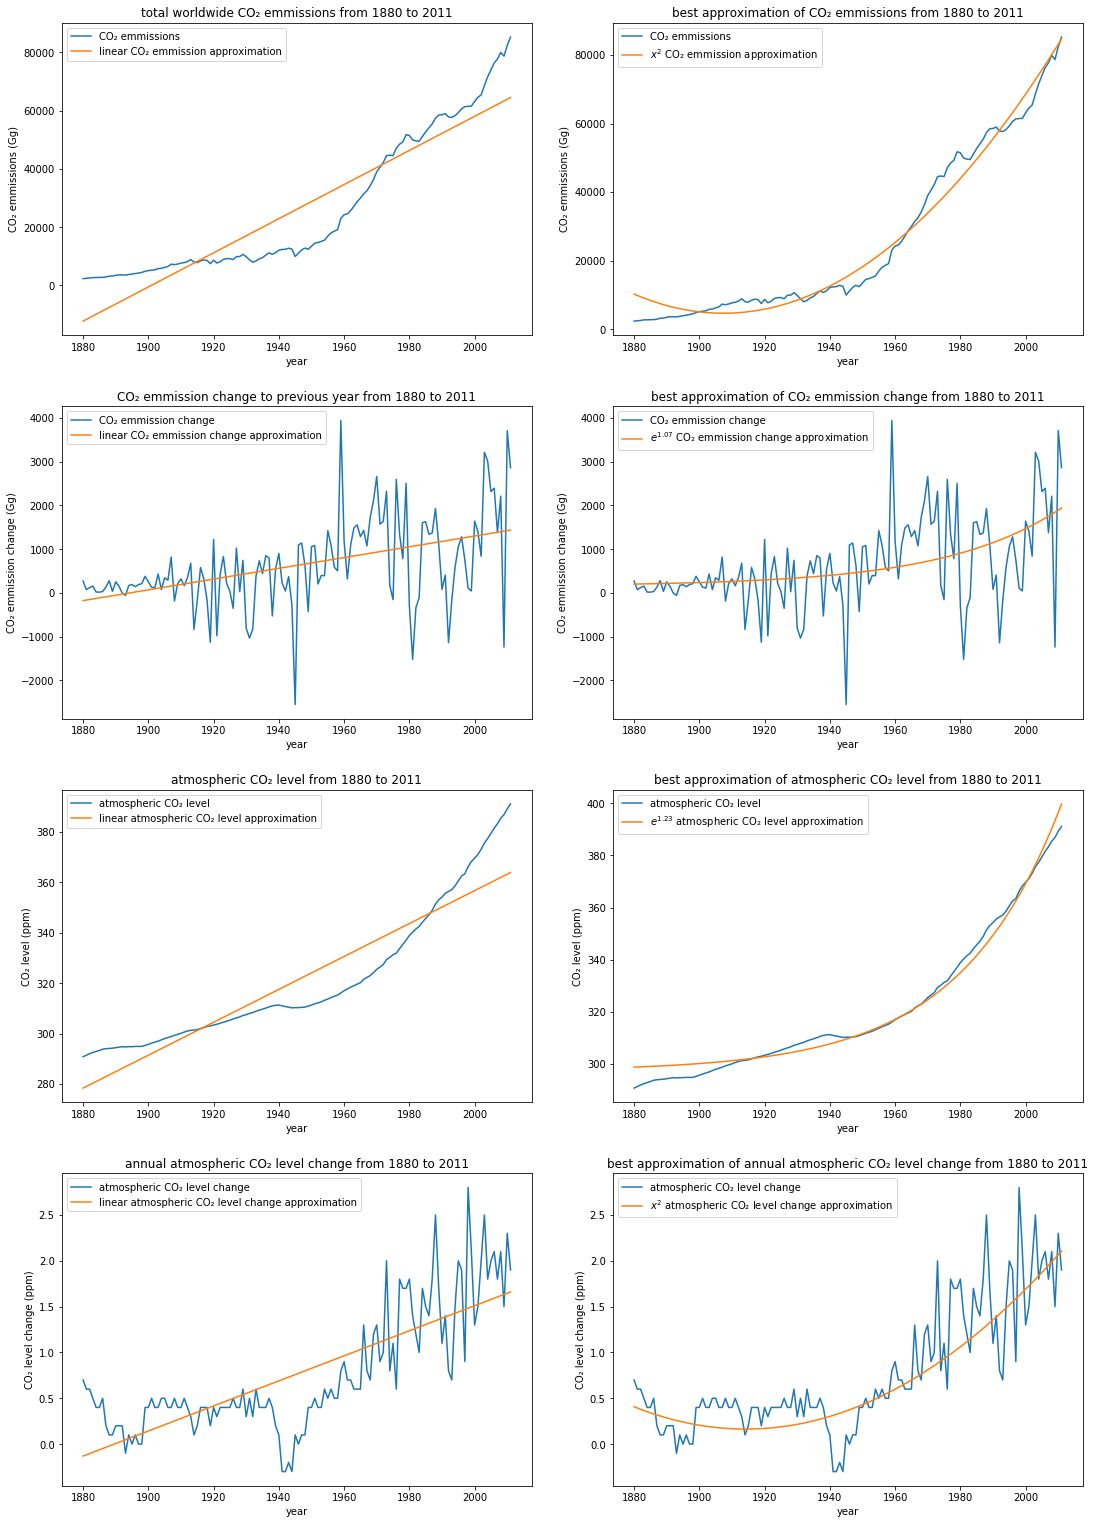

In [53]:
fig, ax = plt.subplots(4, 2, figsize=(16, 22))
fig.tight_layout(pad=5.0)
ax[0, 0].plot(YEARS, co2_emmissions['emmissions'], label='CO₂ emmissions')
ax[0, 0].plot(YEARS, linear_emmissions_approximation['emmission'], label='linear CO₂ emmission approximation')
ax[0, 0].set_title('total worldwide CO₂ emmissions from 1880 to 2011')
ax[0, 0].set_xlabel('year')
ax[0, 0].set_ylabel('CO₂ emmissions (Gg)')
ax[0, 0].legend()
ax[0, 1].plot(YEARS, co2_emmissions['emmissions'], label='CO₂ emmissions')
ax[0, 1].plot(YEARS, best_emmission_approximation['emmission'], label=f'${best_emmission_formated_function}$ CO₂ emmission approximation')
ax[0, 1].set_title('best approximation of CO₂ emmissions from 1880 to 2011')
ax[0, 1].set_xlabel('year')
ax[0, 1].set_ylabel('CO₂ emmissions (Gg)')
ax[0, 1].legend()
ax[1, 0].plot(YEARS, emmission_change['change'], label='CO₂ emmission change')
ax[1, 0].plot(YEARS, linear_emmissions_change_approximation['change'], label='linear CO₂ emmission change approximation')
ax[1, 0].set_title('CO₂ emmission change to previous year from 1880 to 2011')
ax[1, 0].set_xlabel('year')
ax[1, 0].set_ylabel('CO₂ emmission change (Gg)')
ax[1, 0].legend()
ax[1, 1].plot(YEARS, emmission_change['change'], label='CO₂ emmission change')
ax[1, 1].plot(YEARS, best_emmission_change_approximation['change'], label=f'${best_emmission_change_formated_function}$ CO₂ emmission change approximation')
ax[1, 1].set_title('best approximation of CO₂ emmission change from 1880 to 2011')
ax[1, 1].set_xlabel('year')
ax[1, 1].set_ylabel('CO₂ emmission change (Gg)')
ax[1, 1].legend()
ax[2, 0].plot(YEARS, co2_level['level'], label='atmospheric CO₂ level')
ax[2, 0].plot(YEARS, linear_co2_level_approximation['level'], label='linear atmospheric CO₂ level approximation')
ax[2, 0].set_title('atmospheric CO₂ level from 1880 to 2011')
ax[2, 0].set_xlabel('year')
ax[2, 0].set_ylabel('CO₂ level (ppm)')
ax[2, 0].legend()
ax[2, 1].plot(YEARS, co2_level['level'], label='atmospheric CO₂ level')
ax[2, 1].plot(YEARS, best_co2_level_approximation['level'], label=f'${best_co2_level_formated_function}$ atmospheric CO₂ level approximation')
ax[2, 1].set_title('best approximation of atmospheric CO₂ level from 1880 to 2011')
ax[2, 1].set_xlabel('year')
ax[2, 1].set_ylabel('CO₂ level (ppm)')
ax[2, 1].legend()
ax[3, 0].plot(YEARS, co2_level_change['change'], label='atmospheric CO₂ level change')
ax[3, 0].plot(YEARS, linear_co2_level_change_approximation['change'], label='linear atmospheric CO₂ level change approximation')
ax[3, 0].set_title('annual atmospheric CO₂ level change from 1880 to 2011')
ax[3, 0].set_xlabel('year')
ax[3, 0].set_ylabel('CO₂ level change (ppm)')
ax[3, 0].legend()
ax[3, 1].plot(YEARS, co2_level_change['change'], label='atmospheric CO₂ level change')
ax[3, 1].plot(YEARS, best_co2_level_change_approximation['change'], label=f'${best_co2_level_change_formated_function}$ atmospheric CO₂ level change approximation')
ax[3, 1].set_title('best approximation of annual atmospheric CO₂ level change from 1880 to 2011')
ax[3, 1].set_xlabel('year')
ax[3, 1].set_ylabel('CO₂ level change (ppm)')
ax[3, 1].legend()
plt.savefig('results/co2_analysis.pdf')
plt.show()

## Analysis of impact of emmissions on CO<sub>2</sub> level

In [18]:
linear_emmission_vs_co2_level_change_model = pt.nn.Sequential(
    pt.nn.Linear(1, 1)
)
linear_layer = list(linear_emmission_vs_co2_level_change_model.modules())[1]
weight = pt.nn.init.constant_(linear_layer.weight, 0.0)
bias = pt.nn.init.constant_(linear_layer.bias, 0.0)

In [30]:
emmission_vs_co2_level_change_linear_optim = pt.optim.SGD(linear_emmission_vs_co2_level_change_model.parameters(), lr=LR0)
for i in range(N_EPOCHS):
    if i == N_EPOCHS // 2:
        emmission_vs_co2_level_change_linear_optim = pt.optim.SGD(linear_emmission_vs_co2_level_change_model.parameters(), lr=LR1)
    y_hat = linear_emmission_vs_co2_level_change_model(emmission_y)
    loss = criterion(co2_level_change_y, y_hat)
    loss.backward()
    emmission_vs_co2_level_change_linear_optim.step()
    emmission_vs_co2_level_change_linear_optim.zero_grad()
print(f'MSE for approximation of CO₂ level change from CO₂ emmissions: {round(criterion(linear_emmission_vs_co2_level_change_model(emmission_y) * CO2_LEVEL_CHANGE_Y_STD + CO2_LEVEL_CHANGE_Y_MEAN, co2_level_change_y).item(), 3)}')

MSE for approximation of CO₂ level change from CO₂ emmissions: 0.888


In [31]:
linear_emmissions_vs_co2_level_change_approximation = pd.DataFrame(np.concatenate([emmission_y.detach(), linear_emmission_vs_co2_level_change_model(emmission_y).detach() * CO2_LEVEL_CHANGE_Y_STD + CO2_LEVEL_CHANGE_Y_MEAN], axis=1), columns=['year', 'change'])
linear_emmissions_vs_co2_level_change_approximation['year'] = YEARS
linear_emmissions_vs_co2_level_change_approximation.to_csv('data/linear_co2_level_approximation.csv', index=False)

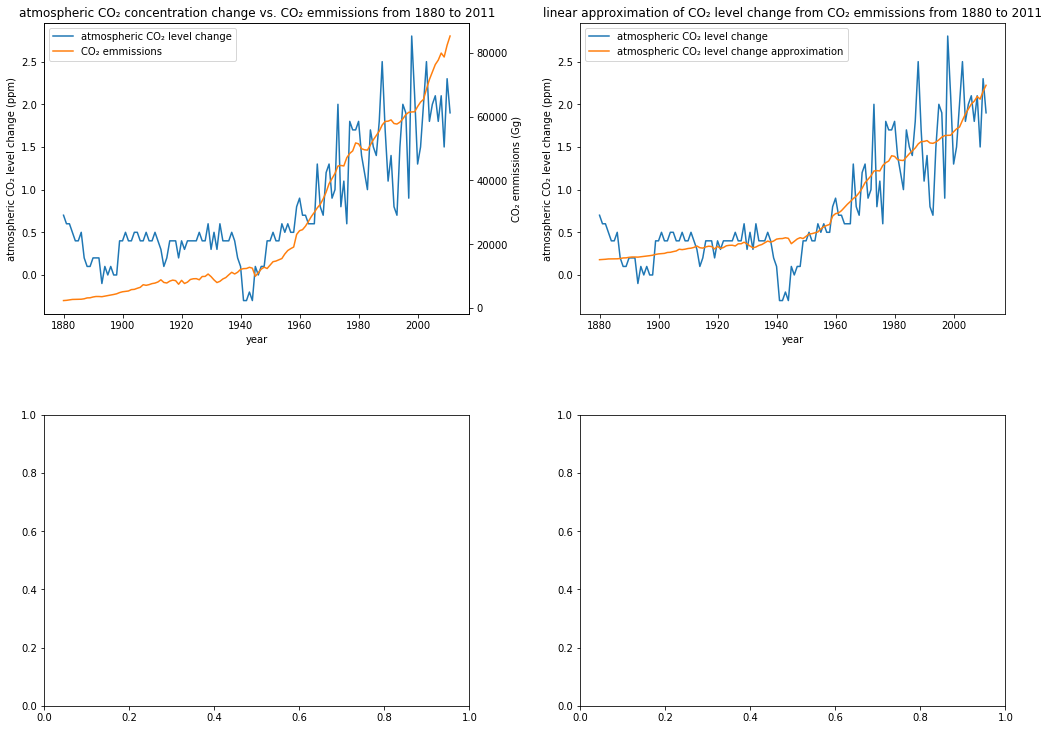

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.tight_layout(pad=8.0)
twin_ax = np.array([[None for _ in _] for _ in ax])
twin_ax[0, 0] = ax[0, 0].twinx()
ax[0, 0].plot(YEARS, co2_level_change['change'], label='atmospheric CO₂ level change')
ax[0, 0].set_ylabel('atmospheric CO₂ level change (ppm)')
twin_ax[0, 0].plot(YEARS, co2_emmissions['emmissions'], c='C1')
twin_ax[0, 0].set_ylabel('CO₂ emmissions (Gg)')
ax[0, 0].plot([], [], label='CO₂ emmissions')
ax[0, 0].set_title('atmospheric CO₂ concentration change vs. CO₂ emmissions from 1880 to 2011')
ax[0, 0].set_xlabel('year')
ax[0, 0].legend()
ax[0, 1].plot(YEARS, co2_level_change['change'], label='atmospheric CO₂ level change')
ax[0, 1].plot(YEARS, linear_emmissions_vs_co2_level_change_approximation['change'], label='atmospheric CO₂ level change approximation')
ax[0, 1].set_ylabel('atmospheric CO₂ level change (ppm)')
ax[0, 1].set_title('linear approximation of CO₂ level change from CO₂ emmissions from 1880 to 2011')
ax[0, 1].set_xlabel('year')
ax[0, 1].legend()
plt.savefig('results/emmissions_impact_analysis.pdf')
plt.show()